In [15]:
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [16]:
# 定义模型
class CellCountingCNN(nn.Module):
    def __init__(self):
        super(CellCountingCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 65 * 87, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [17]:
# 加载多个模型
def load_models(model_paths, device):
    models = []
    for path in model_paths:
        model = CellCountingCNN()
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint, strict=False)
        model.eval().to(device)
        models.append(model)
    return models

In [18]:
# 处理单张图像 (多模型加权平均)
def ensemble_predict(models, image_path, device, weights=None):
    transform = transforms.Compose([
        transforms.Resize((520, 696)),
        transforms.ToTensor(),
    ])

    image = Image.open(image_path).convert("L")
    image = transform(image).unsqueeze(0).to(device)
    
    predictions = []
    with torch.no_grad():
        for model in models:
            predictions.append(model(image).item())

    # 加权平均 (如果 weights 为空，则默认均匀加权)
    if weights is None:
        weights = [1 / len(models)] * len(models)
    
    weighted_pred = sum(w * p for w, p in zip(weights, predictions))
    return weighted_pred

In [19]:
# 批量推理
def batch_inference(models, image_dir, device, weights=None):
    predictions = {}
    for img_file in sorted(os.listdir(image_dir)):
        if img_file.endswith(".TIF"):
            img_path = os.path.join(image_dir, img_file)
            prediction = ensemble_predict(models, img_path, device, weights)
            predictions[img_file] = int (prediction)
    return predictions

In [20]:
# 保存结果到 CSV
def save_predictions_to_csv(predictions, output_path):
    df = pd.DataFrame(list(predictions.items()), columns=["Image", "Predicted Cell Count"])
    df.to_csv(output_path, index=False)
    print(f"\nPredictions saved to {output_path}")

In [21]:
#配置推理

# 参数
model_paths = [
    "D:\MechineLearning_Project\AutoCellCounting\model\swa_model_mark2_16_1.pth",
    "D:\MechineLearning_Project\AutoCellCounting\model\swa_model_mark2_16_2.pth",
    "D:\MechineLearning_Project\AutoCellCounting\model\swa_model_mark2_16_3.pth",
    "D:\MechineLearning_Project\AutoCellCounting\model\swa_model_mark2_16_4.pth",
    "D:\MechineLearning_Project\AutoCellCounting\model\swa_model_mark2_16_5.pth",
    "D:\MechineLearning_Project\AutoCellCounting\model\swa_model_mark2_16_6.pth",
    "D:\MechineLearning_Project\AutoCellCounting\model\swa_model_mark2_16_7.pth",
     "D:\MechineLearning_Project\AutoCellCounting\model\swa_model_mark2_16_10.pth",
     "D:\MechineLearning_Project\AutoCellCounting\model\swa_model_mark2_16_12.pth",
      "D:\MechineLearning_Project\AutoCellCounting\model\swa_model_mark2_16_15.pth",
     "D:\MechineLearning_Project\AutoCellCounting\model\swa_model_mark2_16_16.pth" ]
    
image_dir = "D:/MechineLearning_Project/AutoCellCounting/database/test"
output_csv = "D:/MechineLearning_Project/AutoCellCounting/database/predict_output/ensemble_predictions.csv"
test_image_name = "SIMCEPImages_A02_C5_F1_s10_w2.TIF"
test_image_path = os.path.join(image_dir, test_image_name)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型
models = load_models(model_paths, device)
    
# 批量推理
predictions = batch_inference(models, image_dir, device)

# 打印结果
for img_file, pred in predictions.items():
    print(f"{img_file}: Predicted Cell Count = {pred}")
    
# 保存到 CSV
save_predictions_to_csv(predictions, output_csv)

<>:5: SyntaxWarning: invalid escape sequence '\M'
<>:6: SyntaxWarning: invalid escape sequence '\M'
<>:7: SyntaxWarning: invalid escape sequence '\M'
<>:8: SyntaxWarning: invalid escape sequence '\M'
<>:9: SyntaxWarning: invalid escape sequence '\M'
<>:10: SyntaxWarning: invalid escape sequence '\M'
<>:11: SyntaxWarning: invalid escape sequence '\M'
<>:12: SyntaxWarning: invalid escape sequence '\M'
<>:13: SyntaxWarning: invalid escape sequence '\M'
<>:14: SyntaxWarning: invalid escape sequence '\M'
<>:15: SyntaxWarning: invalid escape sequence '\M'
<>:5: SyntaxWarning: invalid escape sequence '\M'
<>:6: SyntaxWarning: invalid escape sequence '\M'
<>:7: SyntaxWarning: invalid escape sequence '\M'
<>:8: SyntaxWarning: invalid escape sequence '\M'
<>:9: SyntaxWarning: invalid escape sequence '\M'
<>:10: SyntaxWarning: invalid escape sequence '\M'
<>:11: SyntaxWarning: invalid escape sequence '\M'
<>:12: SyntaxWarning: invalid escape sequence '\M'
<>:13: SyntaxWarning: invalid escape sequ

SIMCEPImages_A01_C1_F1_s01_w1.TIF: Predicted Cell Count = 1
SIMCEPImages_A01_C1_F1_s01_w2.TIF: Predicted Cell Count = 0
SIMCEPImages_A01_C1_F1_s02_w1.TIF: Predicted Cell Count = 0
SIMCEPImages_A01_C1_F1_s02_w2.TIF: Predicted Cell Count = 0
SIMCEPImages_A01_C1_F1_s03_w1.TIF: Predicted Cell Count = 1
SIMCEPImages_A01_C1_F1_s03_w2.TIF: Predicted Cell Count = 1
SIMCEPImages_A01_C1_F1_s04_w1.TIF: Predicted Cell Count = 1
SIMCEPImages_A01_C1_F1_s04_w2.TIF: Predicted Cell Count = 1
SIMCEPImages_A01_C1_F1_s05_w1.TIF: Predicted Cell Count = 1
SIMCEPImages_A01_C1_F1_s05_w2.TIF: Predicted Cell Count = 1
SIMCEPImages_A01_C1_F1_s08_w1.TIF: Predicted Cell Count = 0
SIMCEPImages_A02_C5_F1_s10_w2.TIF: Predicted Cell Count = 4
SIMCEPImages_B17_C70_F4_s15_w1.TIF: Predicted Cell Count = 68
SIMCEPImages_B17_C70_F4_s15_w2.TIF: Predicted Cell Count = 67
SIMCEPImages_B17_C70_F4_s16_w1.TIF: Predicted Cell Count = 68
SIMCEPImages_B17_C70_F4_s16_w2.TIF: Predicted Cell Count = 65
SIMCEPImages_B17_C70_F4_s17_w1.T

In [22]:
# --- 计算误差 ---
def compute_errors(predictions, labels):
    errors = {}
    for img_file, pred in predictions.items():
        actual = labels.get(img_file, None)
        if actual is not None:
            errors[img_file] = pred - actual
    return errors


In [23]:
# --- 可视化误差 ---
def visualize_error(predictions, labels, errors):
    fig, ax = plt.subplots(1, 2, figsize=(14, 7))

    # 1. 散点图：预测值 vs 实际值
    actual_vals = [labels[img] for img in predictions if img in labels]
    pred_vals = [pred for img, pred in predictions.items() if img in labels]
    
    ax[0].scatter(actual_vals, pred_vals, color='b', label='Predictions')
    ax[0].plot([min(actual_vals), max(actual_vals)], [min(actual_vals), max(actual_vals)], 'r--', label='Ideal Prediction')
    ax[0].set_xlabel("Actual Cell Count")
    ax[0].set_ylabel("Predicted Cell Count")
    ax[0].set_title("Prediction vs Actual")
    ax[0].legend()

    # 2. 误差图：预测误差
    error_vals = [errors[img] for img in predictions if img in errors]
    
    ax[1].bar(errors.keys(), error_vals, color='g', label='Error')
    ax[1].set_xlabel("Image")
    ax[1].set_ylabel("Prediction Error")
    ax[1].set_title("Prediction Error for Each Image")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [24]:
# 从文件名中提取标签
"""
    函数名: parse_label_from_filename.
    函数功能: 从文件名中提取细胞数量(cells)和模糊程度(blur)的标签.
    例如, 对于文件名 SIMCEPImages_1_1;_1_1.TIF, cells=1.
"""
def parse_label_from_filename(filename):
    match = re.search(r"C(\d+)", filename)
    if match:
        return int(match.group(1))  # 返回细胞数量
    else:
        raise ValueError(f"无法从文件名 '{filename}' 中提取细胞数量！")
    
def generate_labels(image_dir):
    labels = {}
    image_files = sorted(os.listdir(image_dir))  # 按文件名排序，确保一致性
    for img_file in image_files:
        label = parse_label_from_filename(img_file)
        labels[img_file] = label
    return labels

{'SIMCEPImages_A01_C1_F1_s01_w1.TIF': 1, 'SIMCEPImages_A01_C1_F1_s01_w2.TIF': 1, 'SIMCEPImages_A01_C1_F1_s02_w1.TIF': 1, 'SIMCEPImages_A01_C1_F1_s02_w2.TIF': 1, 'SIMCEPImages_A01_C1_F1_s03_w1.TIF': 1, 'SIMCEPImages_A01_C1_F1_s03_w2.TIF': 1, 'SIMCEPImages_A01_C1_F1_s04_w1.TIF': 1, 'SIMCEPImages_A01_C1_F1_s04_w2.TIF': 1, 'SIMCEPImages_A01_C1_F1_s05_w1.TIF': 1, 'SIMCEPImages_A01_C1_F1_s05_w2.TIF': 1, 'SIMCEPImages_A01_C1_F1_s08_w1.TIF': 1, 'SIMCEPImages_A02_C5_F1_s10_w2.TIF': 5, 'SIMCEPImages_B17_C70_F4_s15_w1.TIF': 70, 'SIMCEPImages_B17_C70_F4_s15_w2.TIF': 70, 'SIMCEPImages_B17_C70_F4_s16_w1.TIF': 70, 'SIMCEPImages_B17_C70_F4_s16_w2.TIF': 70, 'SIMCEPImages_B17_C70_F4_s17_w1.TIF': 70, 'SIMCEPImages_B17_C70_F4_s18_w2.TIF': 70, 'SIMCEPImages_B17_C70_F4_s19_w1.TIF': 70, 'SIMCEPImages_B17_C70_F4_s19_w2.TIF': 70, 'SIMCEPImages_B17_C70_F4_s20_w1.TIF': 70, 'SIMCEPImages_B17_C70_F4_s20_w2.TIF': 70, 'SIMCEPImages_B17_C70_F4_s22_w1.TIF': 70, 'SIMCEPImages_B17_C70_F4_s22_w2.TIF': 70, 'SIMCEPImages_B

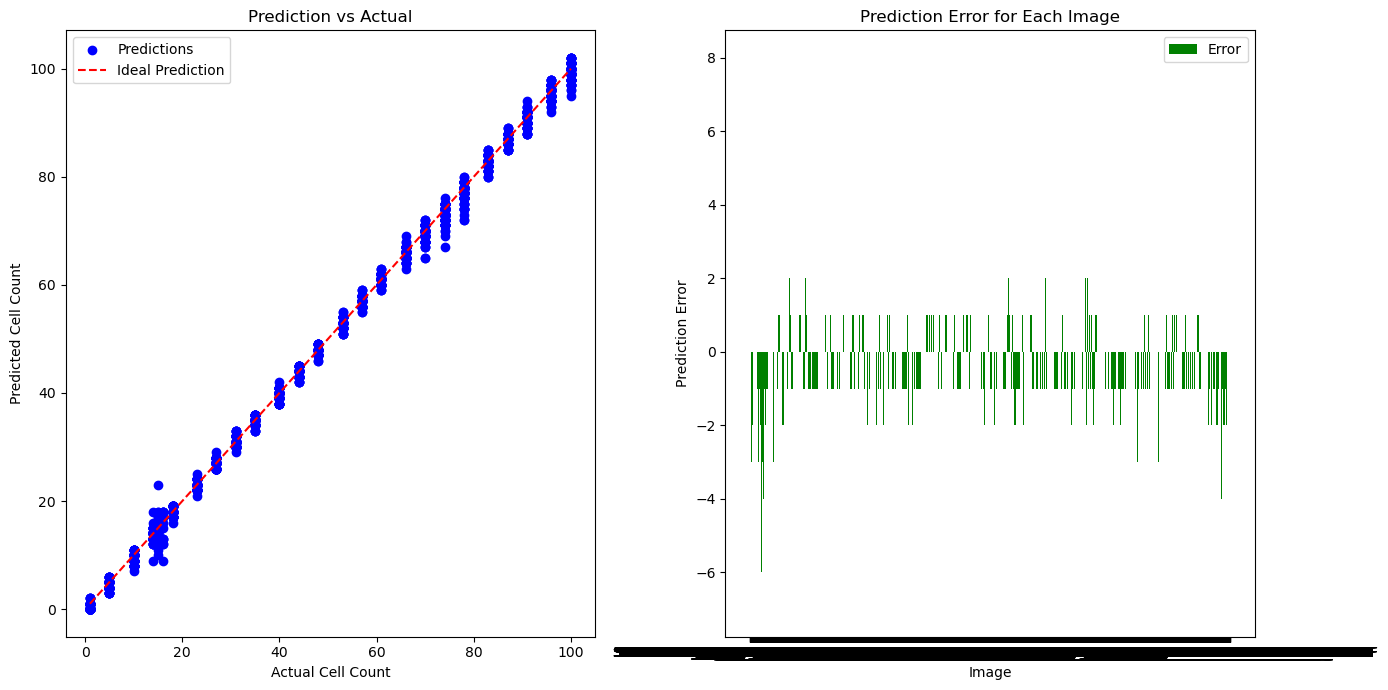

In [25]:
labels = generate_labels(r"D:\MechineLearning_Project\AutoCellCounting\database\test")

print(labels)

errors = compute_errors(predictions, labels)

# 可视化误差
visualize_error(predictions, labels, errors)

In [26]:
# --- 计算误差指标 ---
def evaluate_model(predictions, labels, threshold=0.1):

    y_true, y_pred = [], []
    
    for filename, true_value in labels.items():
        if filename in predictions:
            y_true.append(true_value)
            y_pred.append(predictions[filename])
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 计算误差指标
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # 计算“准确率”：误差小于 threshold（如 10%）
    error_ratio = np.abs((y_pred - y_true) / y_true)
    accuracy = np.mean(error_ratio < threshold) * 100  # 计算百分比

    return mae, rmse, r2, accuracy

In [27]:
# 计算误差指标
mae, rmse, r2, accuracy = evaluate_model(predictions, labels)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2}")
print(f"Accuracy (within 10%): {accuracy:.2f}%")

MAE: 0.68
RMSE: 1.03
R^2 Score: 0.9988292135821217
Accuracy (within 10%): 92.14%
